## Correlation Analysis of Miami Real Estate Market
#### By: Ryan Taron


###Dataset

The dataset was downloaded from Kaggle on the following page: 

https://www.kaggle.com/datasets/deepcontractor/miami-housing-dataset?resource=download

This dataset contains data on 13,932 single family homes near Miami. The following is a list of variables: 
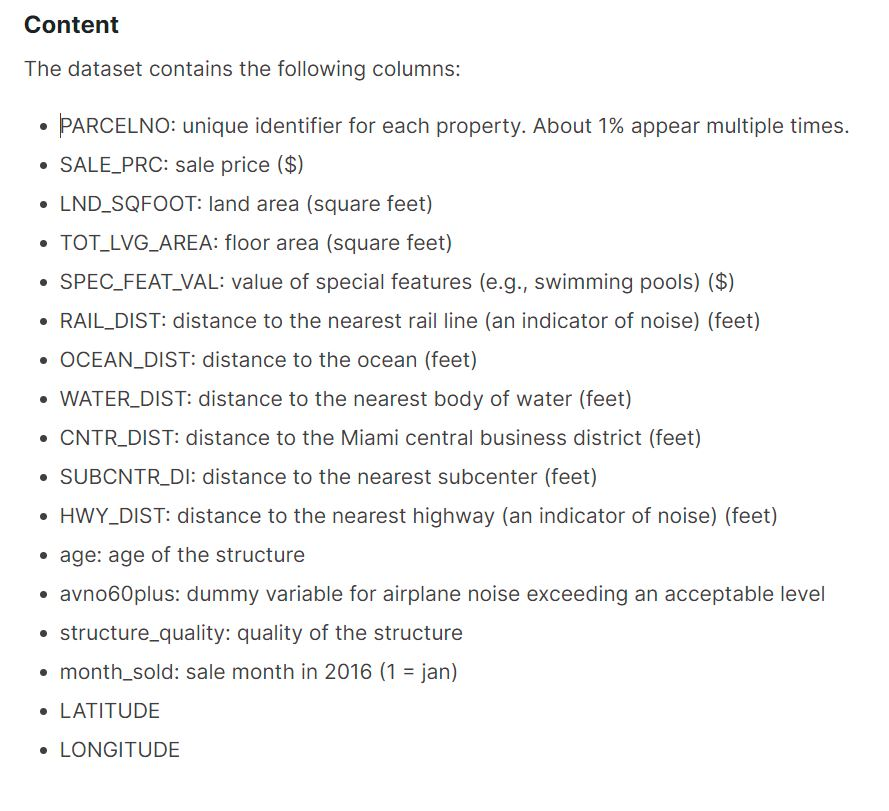

###Cleaning

In [ ]:
#import libraries. We had to install pyspark using the following line, but commented it out after it was installed.
#!pip install pyspark
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Read csv file
from google.colab import files
data_to_load = files.upload()
houses = ps.read_csv("miami-housing.csv")
houses.head()

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


Importing the csv file to the notebook completed without issue

###Removing Duplicates

In [ ]:
#checking for rows that are duplicated
print(houses.shape[0], houses.to_spark().distinct().count())

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


13932 13932


No rows seem to be duplicated, as we have 13932 rows and 13932 distinct counts

Duplicates where only PARCELNO differs to see that no sale was counted twice


In [ ]:
#dataset after removing PARCELNO
no_ids = (
    houses[[col for col in houses.columns if col != 'PARCELNO']]
)

no_ids.head()

,LATITUDE,LONGITUDE,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


In [ ]:
#count the number of rows that are distinct after removing PARCELNO to check if there are rows where only PARCELNO differs
no_ids.shape[0], no_ids.to_spark().distinct().count()

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


(13932, 13932)

No duplicate rows were found in this dataset with this method

Duplicated ID(PARCELNO)

In [ ]:
#are there rows with the same PARCELNO? It is fathomable that a house may be sold more than once in a given year. Column descriptions also claim that roughly 1% of the dataset have repeated PARCELNO
houses.shape[0], houses['PARCELNO'].nunique()

(13932, 13776)

The results of this line of code indicates that among 13932 rows, there are 156 rows that have a PARCELNO not unique to themselves. However, as we have already verified all rows are unique when PARCELNO is removed, and because a house can be sold more than once a year, we know that none of the 156 rows with nonunique PARCELNO have to be dropped. In the column descriptions above, the owner of the dataset also discloses that around 1% of rows will have nonunique PARCELNOs. 

###Missing Values

In [ ]:
#examine if there are any rows with missing values
x = houses.isna().sum(axis=1)
x[x >= 1].shape[0]

0

We seem to have no missing values in our dataset. As expected from a dataset with a usability rating of 10.0 on kaggle.

###Desriptive Statistics

In [ ]:
#using describe() to show descriptive statistics for our dataset
#we use default dataset as we have made no changes in the duplicates and missing values sections
houses.drop(columns = ['LATITUDE','LONGITUDE', 'PARCELNO'], axis = 1).describe()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
count,1.393200e+04,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000,13932.000000
mean,3.999419e+05,8620.879917,2058.044574,9562.493468,8348.548715,31690.993798,11960.285235,68490.327132,41115.047265,7723.770693,30.669251,0.014930,6.655828,3.513997
std,3.172147e+05,6070.088742,813.538535,13890.967782,6178.027333,17595.079468,11932.992369,32008.474808,22161.825935,6068.936108,21.153068,0.121276,3.301523,1.097444
min,7.200000e+04,1248.000000,854.000000,0.000000,10.500000,236.100000,0.000000,3825.600000,1462.800000,90.200000,0.000000,0.000000,1.000000,1.000000
25%,2.350000e+05,5400.000000,1470.000000,810.000000,3299.300000,18077.400000,2675.400000,42818.600000,23995.200000,2997.900000,14.000000,0.000000,4.000000,2.000000
50%,3.100000e+05,7500.000000,1877.000000,2765.000000,7104.400000,28532.800000,6918.200000,65849.200000,41105.100000,6158.000000,26.000000,0.000000,7.000000,4.000000
75%,4.275000e+05,9125.000000,2471.000000,12328.000000,12101.400000,44305.700000,19197.200000,89349.000000,53936.800000,10852.000000,46.000000,0.000000,9.000000,4.000000
max,2.650000e+06,57064.000000,6287.000000,175020.000000,29621.500000,75744.900000,50399.800000,159976.500000,110553.800000,48167.300000,96.000000,1.000000,12.000000,5.000000


SALE_PRC is our most important column, and the descriptive statistics for it are particularly noteworthy. Homes in Miami sold in the year 2016 had an average price of $400,000 across 13,932 entries. The standard deviation for this column is quite high, at 317,215. The cheapest home sold was 72,000 dollars and the most expensive home was 2,650,000 dollars. The median was 310,000. We will need to observe how these values change after the outlier analysis.





###Visualization


In [ ]:
#a histogram to view range of home prices, taken from Spark_preprocessing.ipnyb
def plot_hist(df, features, n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figheight(15)
    fig.set_figwidth(25)
    for i in range(len(features)):
        df[features[i]].hist(ax=ax[i//n_cols, i%n_cols], title=features[i])


UsageError: Line magic function `%matplot` not found.


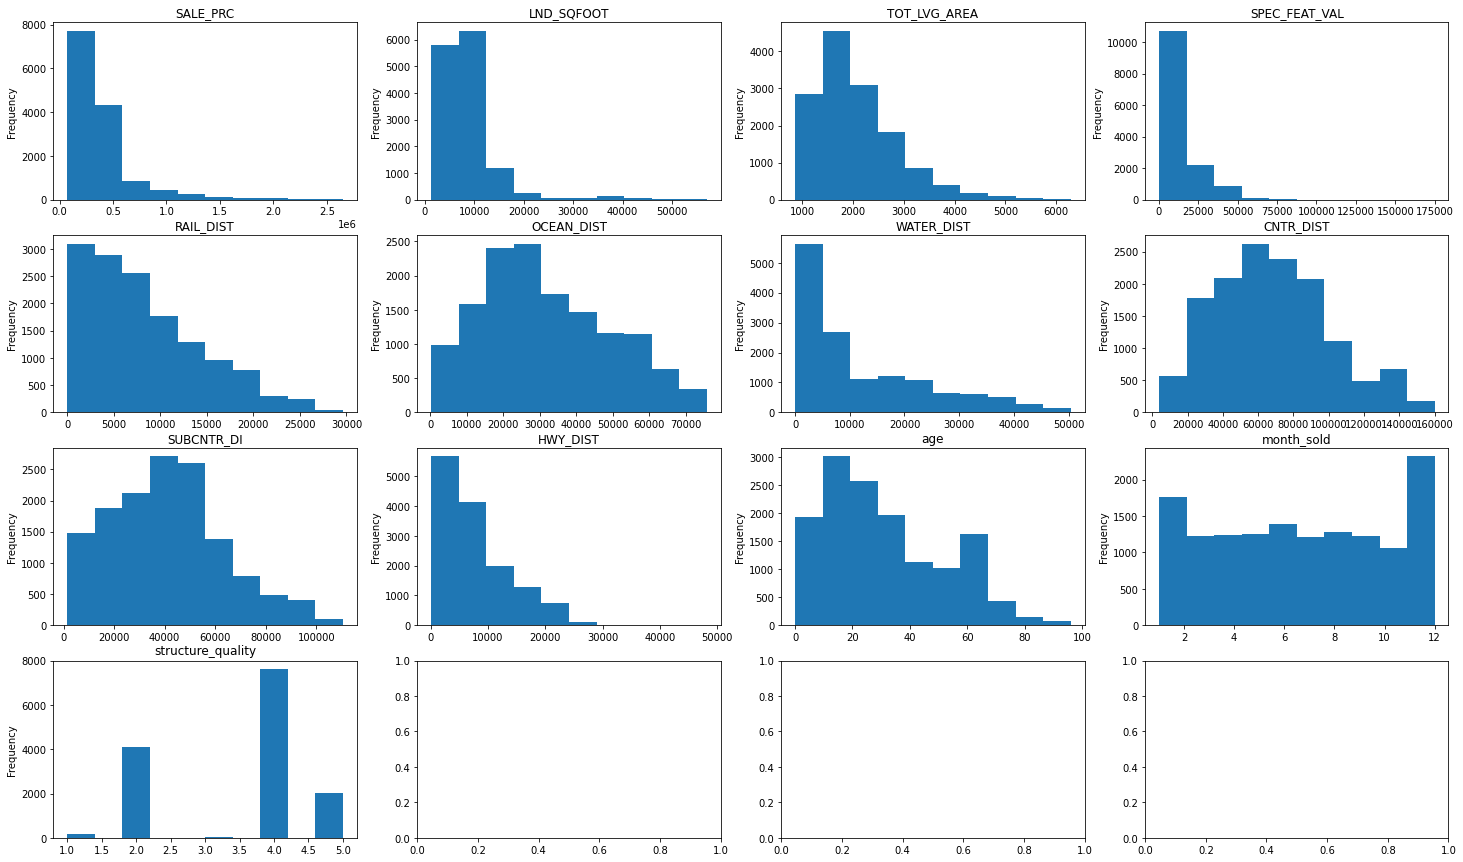

In [ ]:
ps.set_option('plotting.backend', 'matplotlib')
features = ['SALE_PRC', 'LND_SQFOOT', 'TOT_LVG_AREA','SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST', 'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'age','month_sold', 'structure_quality']
plot_hist(df=houses, features=features, n_rows=4, n_cols=4)
%matplot plt

There seem to be a few houses that are high in price and area, but no clear outliers. There is a possibility outliers were already cleaned up by the owner of the dataset. However, we will have to decide on what to do with the outliers after observing graphs after running analysis.

###Outlier Analysis


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='LND_SQFOOT', ylabel='SALE_PRC'>

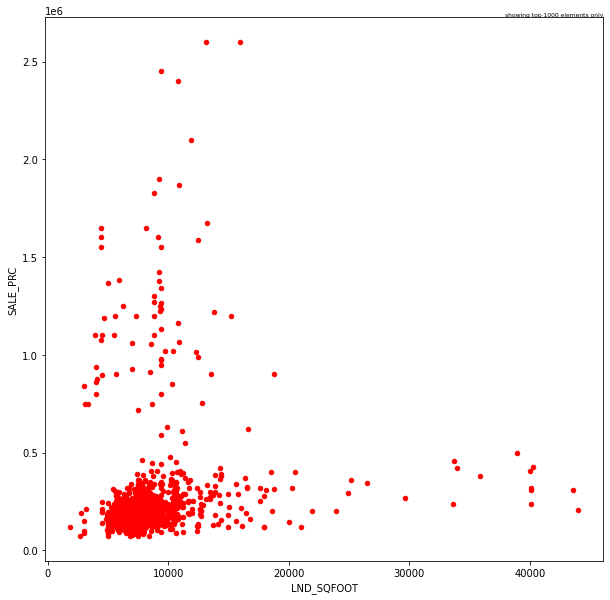

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='LND_SQFOOT', y='SALE_PRC', figsize=(10,10), c='red')

With most listings being situated on a lot that is less than 20,000 sqft, a significant majority of the properties were sold for less than $500,000, with the exception of occasional outliers.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='TOT_LVG_AREA', ylabel='SALE_PRC'>

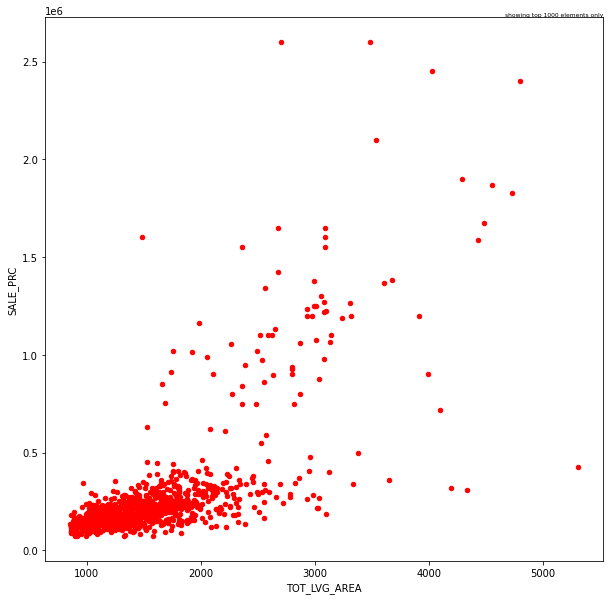

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='TOT_LVG_AREA', y='SALE_PRC', figsize=(10,10), c='red')

With most listings having a having a total living area that is less than 3,000 sqft, a significant majority of the properties were sold for less than $500,000, with the exception of occasional outliers.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='SPEC_FEAT_VAL', ylabel='SALE_PRC'>

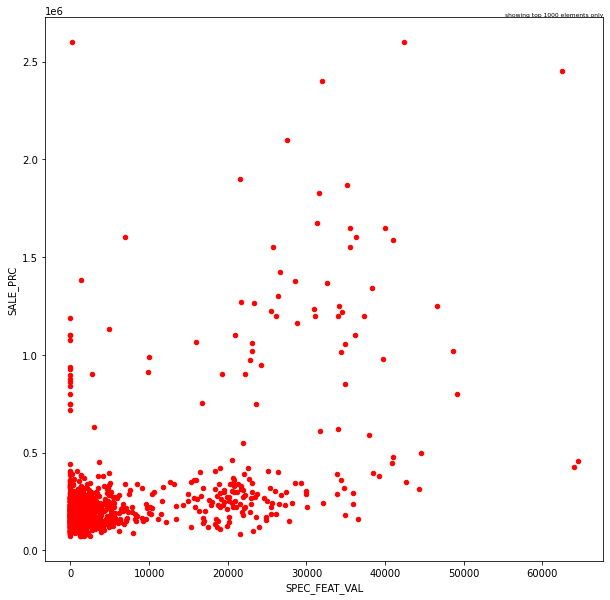

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='SPEC_FEAT_VAL', y='SALE_PRC', figsize=(10,10), c='red')

Most listings had feature values less than $40,000.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='RAIL_DIST', ylabel='SALE_PRC'>

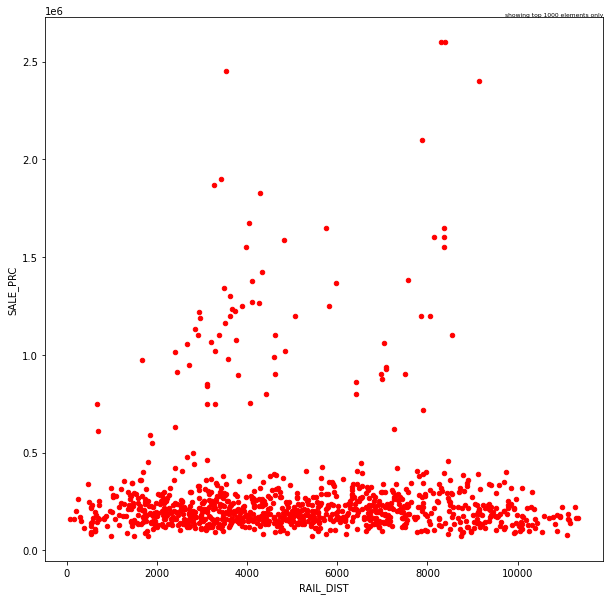

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='RAIL_DIST', y='SALE_PRC', figsize=(10,10), c='red')

Regardless of distance to rail, most listings were still less than $500,000.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='OCEAN_DIST', ylabel='SALE_PRC'>

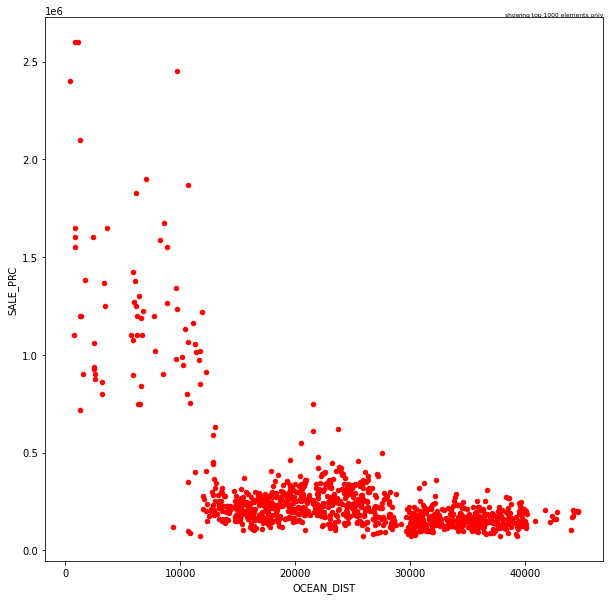

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='OCEAN_DIST', y='SALE_PRC', figsize=(10,10), c='red')

A majority of listings that were less than 10,000 feet from the ocean sold for over $500,000.

With very few outliers, a majority of listings that were more than 10,000 feet from the ocean sold for less than $500,000.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='WATER_DIST', ylabel='SALE_PRC'>

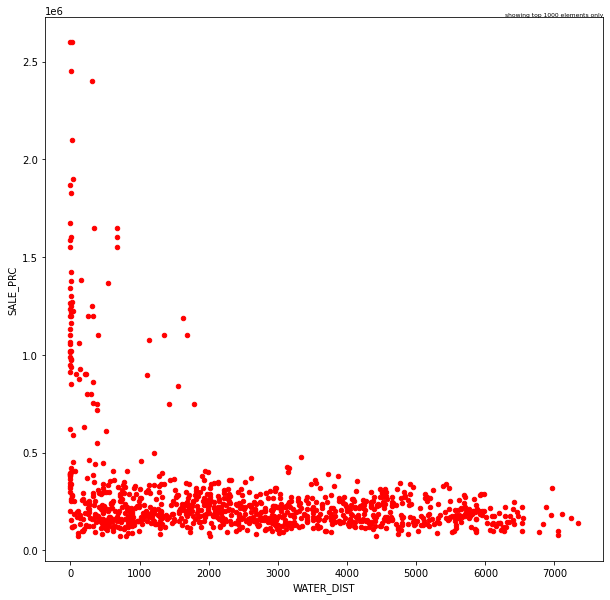

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='WATER_DIST', y='SALE_PRC', figsize=(10,10), c='red')

With very few outliers, most listings that were more than 1,000 feet from any body of water were sold for less than $500,000.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='CNTR_DIST', ylabel='SALE_PRC'>

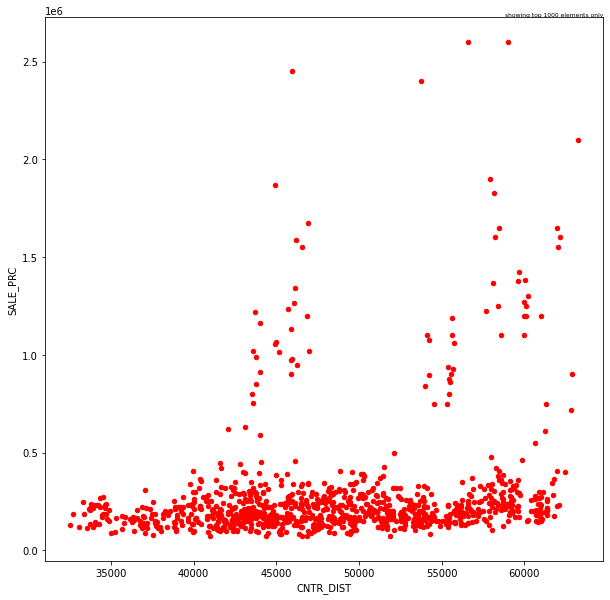

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='CNTR_DIST', y='SALE_PRC', figsize=(10,10), c='red')

With very few outliers, most listings regardless of distance to a main center were sold for less than $500,000.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='SUBCNTR_DI', ylabel='SALE_PRC'>

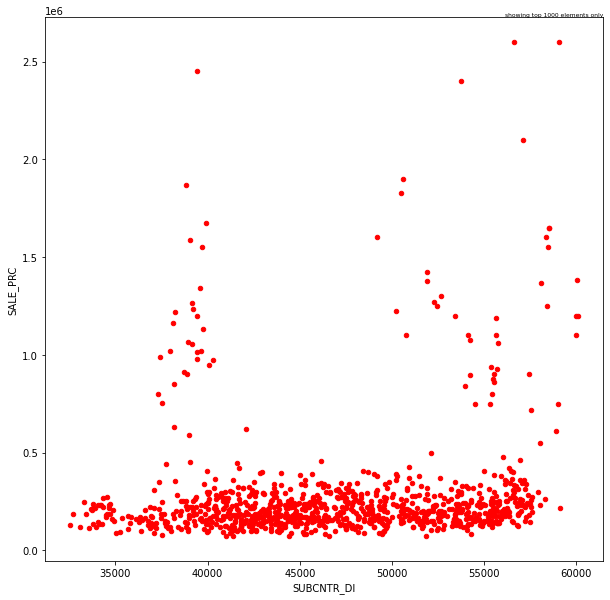

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='SUBCNTR_DI', y='SALE_PRC', figsize=(10,10), c='red')

With very few outliers, most listings regardless of distance to a subcenter were sold for less than $500,000. This scatter plot implies that the subcenter is close to the city center, as this graph somewhat resembles the scatter plot prior.


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='HWY_DIST', ylabel='SALE_PRC'>

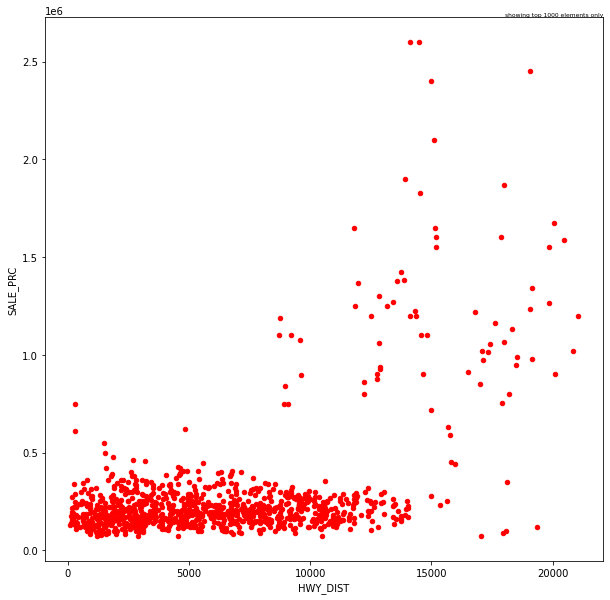

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='HWY_DIST', y='SALE_PRC', figsize=(10,10), c='red')

With very few outliers, most listings that were less than 15,000 feet from a highway almost exclusively sold for less than $500,000.

With very few outliers, most listings that were more than 15,000 feet from a highway sold for more than $500,000.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='age', ylabel='SALE_PRC'>

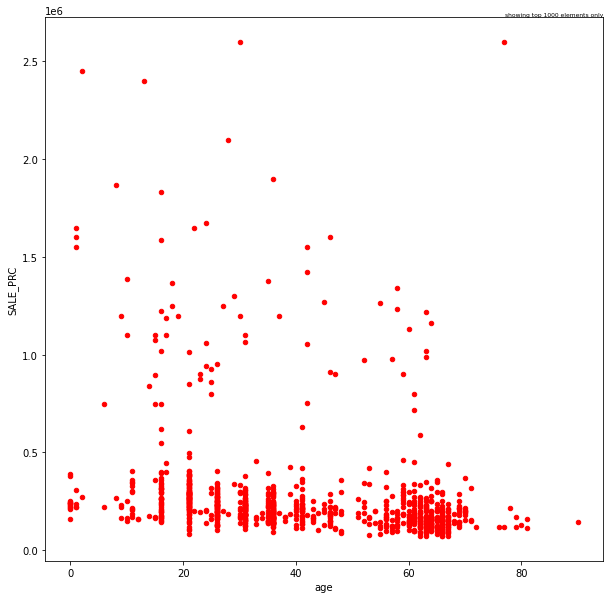

In [ ]:
# organize the scatter plot
houses.plot.scatter(x='age', y='SALE_PRC', figsize=(10,10), c='red')

With few outliers, a majority of listings were still sold for less than $500,000 regardless of age.

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='SUBCNTR_DI', ylabel='CNTR_DIST'>

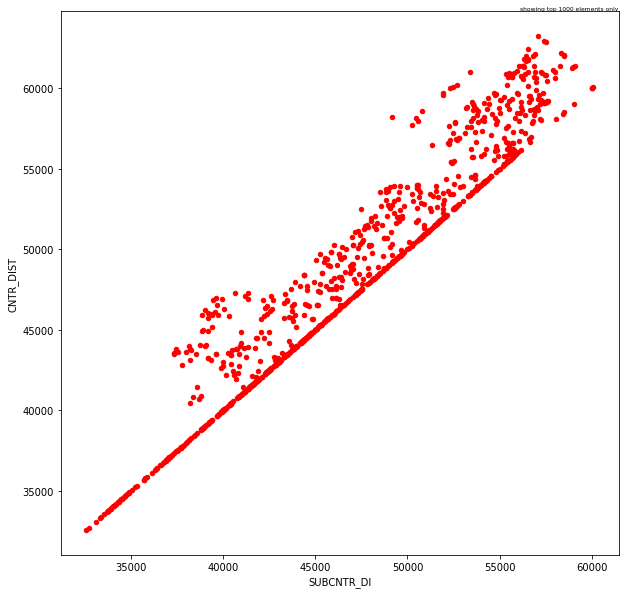

In [ ]:
#checking for correlation between CNTR_DIST and SUBCENTER_DI
houses.plot.scatter(x='SUBCNTR_DI', y='CNTR_DIST', figsize=(10,10), c='red')

The above graph is self-explanatory: CNTR-DIST and SUBCENTER_DIST are strongly and positively correlated (Kind of implied by their column names). 

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='TOT_LVG_AREA', ylabel='LND_SQFOOT'>

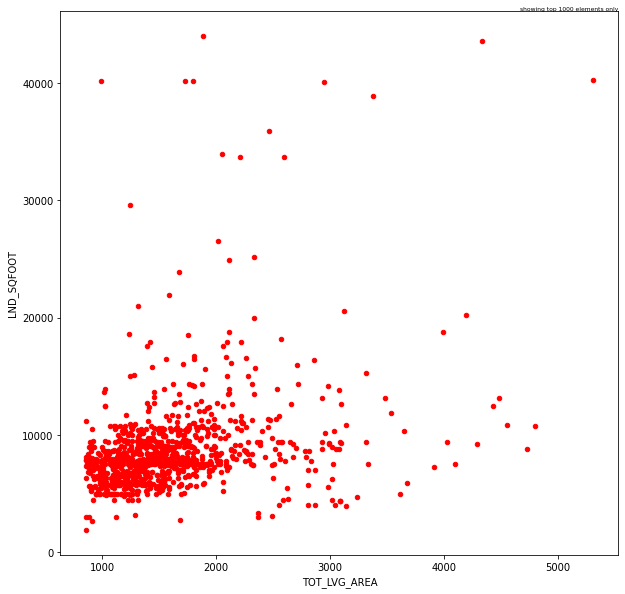

In [ ]:
#Checking correlation between total area and square footage.
houses.plot.scatter(x='TOT_LVG_AREA', y='LND_SQFOOT', figsize=(10,10), c='red')

Although the column names are similar, we see very little correlation between total living area and square footage of a property.

###Outlier Analysis with Z-scores

In [ ]:
#adding a column for price z score. Using values from descriptive statistics as average and standard deviation
avg = houses['SALE_PRC'].mean()
std = houses['SALE_PRC'].std()
houses_outlier = houses
houses_outlier['price_z'] = ((houses_outlier['SALE_PRC']-avg)/std)
houses_outlier.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality,price_z
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4,0.126281
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4,-0.160591
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4,1.261159
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4,1.853817
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4,1.119299


In [ ]:
#Filter out columns with z-scores of 3 or higher and verify if less than 3% of rows were dropped
houses_outlier= houses_outlier[abs(houses_outlier["price_z"]) < 3]
houses_outlier.shape

(13581, 18)

This cell reveals that 351 columns were removed when setting the z-score at +/- 3.0. As 351 rows account for roughly 2.5% of the dataset, we are satisfied with this z-score and the resulting dataset. We will now observe changes to the descriptive statistics and any histograms.

###Rerunning Descriptive Statistics

In [ ]:
#using describe() to show descriptive statistics for our dataset
#we use default dataset as we have made no changes in the duplicates and missing values sections
houses_outlier.drop(columns = ['LATITUDE','LONGITUDE', 'PARCELNO'], axis = 1).describe()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality,price_z
count,1.358100e+04,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000,13581.000000
mean,3.630637e+05,8431.238569,2008.881894,8911.997497,8358.808276,32237.266056,12188.718916,69269.304948,41706.593366,7622.707164,30.855754,0.015316,6.660555,3.482733,-0.116257
std,2.139170e+05,5756.234704,743.732530,13074.584945,6171.533177,17374.308440,11978.302046,31962.125005,22026.269451,6023.975125,21.173872,0.122809,3.302910,1.089554,0.674360
min,7.200000e+04,1248.000000,854.000000,0.000000,10.500000,308.800000,0.000000,3825.600000,1462.800000,90.200000,0.000000,0.000000,1.000000,1.000000,-1.033817
25%,2.300000e+05,5368.000000,1459.000000,780.000000,3299.300000,18645.400000,2833.100000,43753.500000,25032.200000,2959.600000,14.000000,0.000000,4.000000,2.000000,-0.535732
50%,3.070000e+05,7500.000000,1857.000000,2667.000000,7138.800000,29125.200000,7142.500000,66959.700000,41676.500000,6074.900000,26.000000,0.000000,7.000000,4.000000,-0.292994
75%,4.130000e+05,9000.000000,2415.000000,9619.000000,12119.700000,44573.100000,19537.200000,90247.000000,54515.200000,10640.100000,46.000000,0.000000,9.000000,4.000000,0.041165
max,1.350000e+06,57064.000000,6261.000000,175020.000000,29621.500000,75744.900000,50399.800000,159976.500000,110553.800000,48167.300000,96.000000,1.000000,12.000000,5.000000,2.995000


Our dataset after removing outliers has 13581 rows of data, has a mean of 363,064 dollars, a noticeably different stdev at 213,917 (compared to the previous 317,215), a median of 307,000, and a min and max of 72,000 and 1,350,000 respectively. With the maximum house price roughly half as before while the minimum price remains the same, we can see there were a few properties that were very top heavy and skewed our data. 

###Redrawing Histograms


UsageError: Line magic function `%matplot` not found.


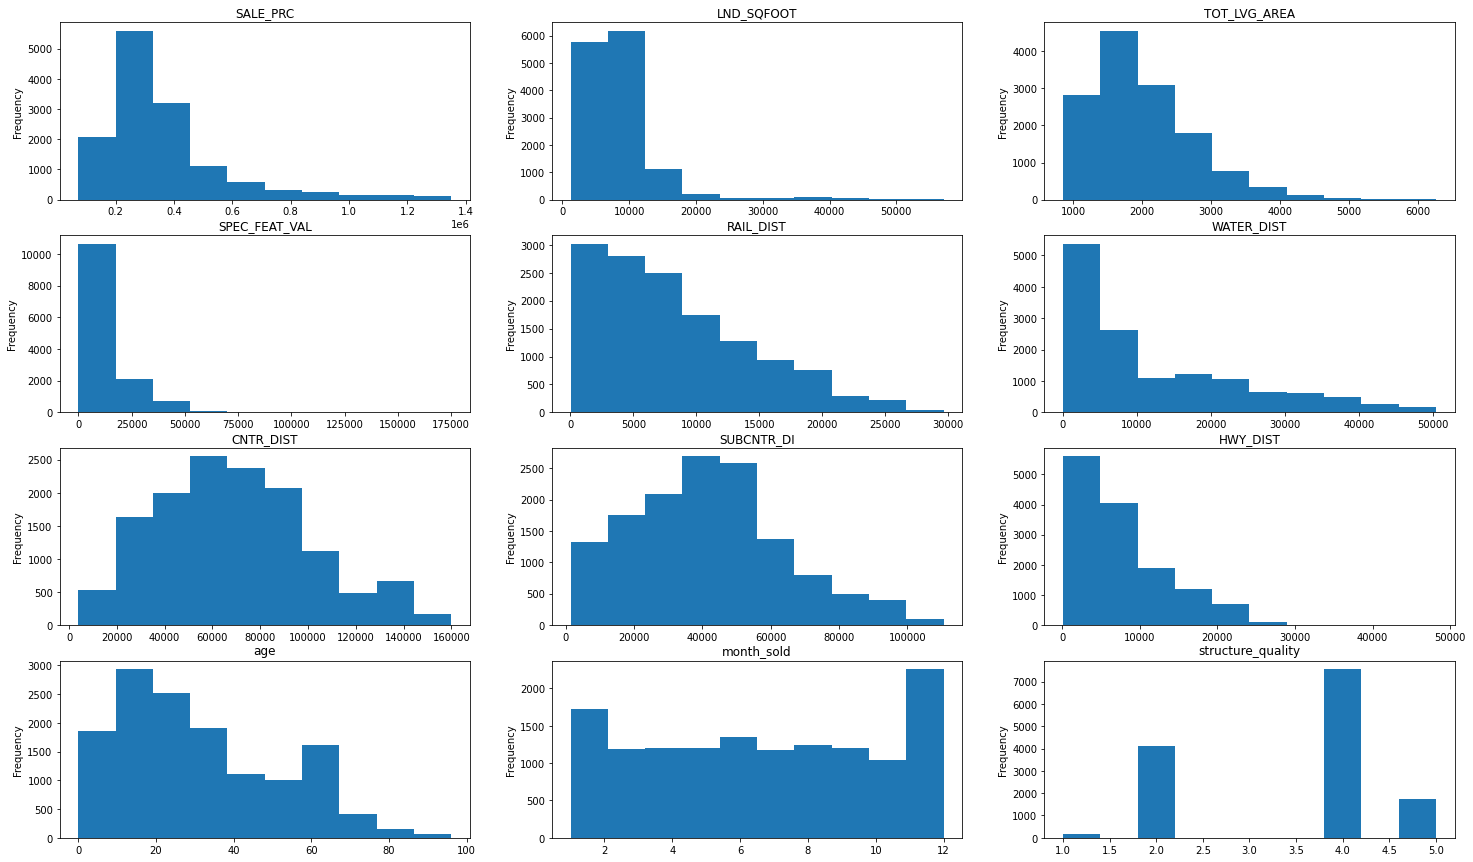

In [ ]:
#Redrawing histograms with the same params, but with outliers removed
features = ['SALE_PRC', 'LND_SQFOOT', 'TOT_LVG_AREA','SPEC_FEAT_VAL', 'RAIL_DIST','WATER_DIST','CNTR_DIST','SUBCNTR_DI','HWY_DIST', 'age', 'month_sold', 'structure_quality']
plot_hist(df=houses_outlier, features=features, n_rows=4, n_cols=3)
%matplot plt

After the removal of outliers, each chart is closer to a standard distribution. It should be possible to remove more house sales at the top, but that would result in removing more than 3% of the dataset. It is interesting to note that the SALE_PRC, LND_SQFOOT, and TOT_LVG_AREA charts are similar in shape, indicating a relationship between price, living area, and square footage. However, exploratory scatter plots between the latter two columns revealed weak a correlation. Distances from city centers and subcenters were strongly and positively correlated, as expected. 